# Notebook 04: Managed vs. Unmanaged Haven (CHF vs. Gold)
#
# **Pair:** Swiss Franc Futures (/6C) vs. Gold Futures (/GC)
# **Thesis:** Tracking the divergence between the "Managed" Haven (CHF)
# and the "Unmanaged" Haven (Gold).
#
# **Classic Correlation (Positive):**
# * **"Global Risk-Off":** A major crisis (e.g., U.S. debt, banking)
#     causes capital to flee the USD/EUR and seek "hard assets."
#     Investors buy both CHF (/6C rises) and Gold (/GC rises).
#
# **Decorrelation (The "Arbitrage"):**
# * **"SNB Intervention":** The crisis drives *too much* capital into CHF,
#     hurting Swiss exporters. The Swiss National Bank (SNB) intervenes
#     by *printing CHF* to *buy foreign assets* (EUR/USD).
# * **The Signal:** This intervention (selling CHF) *caps* the franc's
#     rally. The underlying crisis, however, continues to boost Gold.
# * **Result:** /GC continues to rise while /6C flattens or falls.
#
# **Proxies Used:**
# * `/6C=F` (CHF Future) -> `FXF` (CHF ETF for clean price history)
# * `/GC=F` (Gold Future) -> `GLD` (Gold ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `WSTA`: **SNB Total Sight Deposits (Weekly).** This is the #1
#     intervention proxy. A sudden *increase* means the SNB is
#     printing/selling CHF.
# * `DFII10`: 10-Yr Real Yield (TIPS). A primary driver for Gold,
#     but less so for CHF.

In [1]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [2]:
# Cell 2: API & LLM Configuration (Refactored)
#
# Set up API keys, LLM endpoints, and asset tickers.
# REPLACED: Discontinued EVZCLS with VIXCLS as our global risk/FX vol proxy.
# REMOVED: WSTA from FRED list (we are using the SNB API in Cell 2.5).

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["FXF", "GLD"]
FRED_SERIES_IDS = [
    "DFII10",   # 10-Yr Treasury Real Yield (TIPS)
    "GVZCLS",   # CBOE Gold Volatility Index
    "VIXCLS"    # CBOE VIX Index (Proxy for Global Risk / CHF Vol)
]

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['FXF', 'GLD'] and ['DFII10', 'GVZCLS', 'VIXCLS']


In [3]:
# Cell 2.5: Data Collection - SNB API
#
# Fetch weekly SNB Total Sight Deposits directly from the SNB API.
try:
    print("Fetching SNB Total Sight Deposits (weekly) from SNB API...")

    # SNB API endpoint for weekly sight deposits (JSON format)
    snb_url = "https://data.snb.ch/api/cube/snbgwdchfsgw/data/json/en"
    params = {
        "dimSel": "D0(GI,UEB,TG)",  # All deposit types
        "fromDate": START_DATE.strftime('%Y-%m-%d'),
        "toDate": END_DATE.strftime('%Y-%m-%d')
    }

    # Fetch data
    response = requests.get(snb_url, params=params)
    response.raise_for_status()
    snb_data = response.json()

    # Extract the "Total sight deposits in Swiss francs at the SNB" series
    total_sight_deposits = None
    for ts in snb_data["timeseries"]:
        if ts["header"][0]["dimItem"] == "Total sight deposits in Swiss francs at the SNB":
            total_sight_deposits = ts
            break

    if total_sight_deposits is None:
        raise ValueError("Total sight deposits series not found in API response.")

    # Convert to DataFrame
    df_snb = pd.DataFrame(total_sight_deposits["values"])
    df_snb["date"] = pd.to_datetime(df_snb["date"])
    df_snb["value"] = pd.to_numeric(df_snb["value"], errors="coerce")
    df_snb = df_snb.set_index("date").rename(columns={"value": "SNB_Sight_Deposits"})

    print("✅ Cell 2.5: SNB data fetched successfully.")
    print(df_snb.tail())

except Exception as e:
    print(f"❌ Cell 2.5: SNB data fetch failed: {e}")
    df_snb = pd.DataFrame()  # Create empty DataFrame to avoid downstream errors


Fetching SNB Total Sight Deposits (weekly) from SNB API...


✅ Cell 2.5: SNB data fetched successfully.
            SNB_Sight_Deposits
date                          
2025-10-03            476958.0
2025-10-10            474240.0
2025-10-17            473759.0
2025-10-24            471499.0
2025-10-31            470502.0


In [4]:
# Cell 3: Data Collection - yfinance
#
# Fetch historical price data for our ETF proxies (FXF, GLD).
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")

Fetching yfinance data from 2020-11-04 to 2025-11-03...


/tmp/ipykernel_1126827/3162865277.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)


[*********************100%***********************]  2 of 2 completed

✅ Cell 3: yfinance data fetched successfully.
Ticker             FXF         GLD
Date                              
2025-10-28  111.580002  364.380005
2025-10-29  110.570000  363.000000
2025-10-30  110.309998  370.130005
2025-10-31  109.959999  368.119995
2025-11-03  109.540001  368.779999


In [5]:
# Cell 4: Data Collection - FRED (Refactored)
#
# Fetch historical macro data for our causal drivers from FRED.
# Note: This now includes the volatility indexes.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...


✅ Cell 4: FRED data fetched successfully.
            DFII10  GVZCLS  VIXCLS
2025-10-27    1.73   23.94   15.79
2025-10-28    1.71   24.03   16.42
2025-10-29    1.78   24.70   16.92
2025-10-30    1.82   24.82   16.91
2025-10-31    1.81   22.66   17.44


In [6]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' for weekly/monthly data.
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market), FRED (macro), and SNB (intervention) data.
try:
    # Merge yfinance and FRED data
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')

    # Merge with SNB data
    df = pd.merge(df, df_snb, left_index=True, right_index=True, how='outer')

    # Forward-fill missing values (CRITICAL for weekly SNB data)
    df = df.ffill()

    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()

    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())

except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")


✅ Cell 5: Data consolidated and cleaned.
                   FXF         GLD  DFII10  GVZCLS  VIXCLS  SNB_Sight_Deposits
2025-10-28  111.580002  364.380005    1.71   24.03   16.42            471499.0
2025-10-29  110.570000  363.000000    1.78   24.70   16.92            471499.0
2025-10-30  110.309998  370.130005    1.82   24.82   16.91            471499.0
2025-10-31  109.959999  368.119995    1.81   22.66   17.44            470502.0
2025-11-03  109.540001  368.779999    1.81   22.66   17.44            470502.0


In [7]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
try:
    df_normalized = pd.DataFrame(index=df.index)
    # Apply zscore, handling potential NaNs from different start dates
    for col in df.columns:
        df_normalized[col] = zscore(df[col].dropna())
    
    # Re-fill any NaNs created by z-scoring (if any)
    df_normalized = df_normalized.ffill().dropna()
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                FXF           GLD        DFII10        GVZCLS        VIXCLS  SNB_Sight_Deposits
count  1.302000e+03  1.302000e+03  1.302000e+03  1.302000e+03  1.302000e+03        1.302000e+03
mean  -7.858537e-16  8.731708e-17  8.731708e-17 -8.185976e-16  8.731708e-17       -8.731708e-17
std    1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00        1.000384e+00
min   -2.391325e+00 -1.020388e+00 -1.723603e+00 -2.308731e+00 -1.441162e+00       -1.176452e+00
25%   -5.054447e-01 -6.710766e-01 -1.260919e+00 -5.801742e-01 -7.199995e-01       -8.869967e-01
50%   -1.526879e-01 -4.632609e-01  5.045857e-01 -1.106159e-01 -2.054249e-01       -4.592302e-01
75%    4.440739e-01  4.125204e-01  8.333347e-01  5.137513e-01  5.313739e-01        1.139671e+00
max    2.664366e+00  3.829352e+00  1.287901e+00  5.409474e+00  6.229127e+00        1.492910e+00


In [8]:
# Cell 7: Feature Engineering - Ratios & Spreads
#
# Calculate the key ratios and spreads that define our thesis.
#
# * Ratio: The price of CHF (FXF) divided by the price of Gold (GLD).
#     A FALLING ratio signals Gold is outperforming CHF (our thesis).
# * Causal Feature: The *change* in SNB deposits is the signal.

try:
    # 1. Price Ratio (The Core Signal)
    df['CHF_GLD_Ratio'] = df['FXF'] / df['GLD']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['CHF_GLD_Spread_Norm'] = df_normalized['FXF'] - df_normalized['GLD']
    
    # 3. Causal Feature: SNB Intervention Signal (Week-over-Week Change)
    # A large positive spike = SNB printing/selling CHF.
    df['SNB_Intervention_WoW'] = df['SNB_Sight_Deposits'].diff(7)

    print("✅ Cell 7: Ratios and Spreads calculated.")
    # Show the last 10 rows to capture the weekly diff
    print(df[['CHF_GLD_Ratio', 'SNB_Sight_Deposits', 'SNB_Intervention_WoW']].tail(10))
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            CHF_GLD_Ratio  SNB_Sight_Deposits  SNB_Intervention_WoW
2025-10-21       0.294746            473759.0                -481.0
2025-10-22       0.294635            473759.0                -481.0
2025-10-23       0.293778            473759.0                -481.0
2025-10-24       0.294766            471499.0               -2741.0
2025-10-27       0.303207            471499.0               -2741.0
2025-10-28       0.306219            471499.0               -2260.0
2025-10-29       0.304601            471499.0               -2260.0
2025-10-30       0.298030            471499.0               -2260.0
2025-10-31       0.298707            470502.0               -3257.0
2025-11-03       0.297033            470502.0               -3257.0


In [9]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of FXF and GLD.
# * Positive = "Global Risk-Off" regime.
# * Falling/Negative = "SNB Intervention" regime.

try:
    # First, get daily percentage returns
    df['FXF_pct'] = df['FXF'].pct_change()
    df['GLD_pct'] = df['GLD'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['FXF_pct'].rolling(window=30).corr(df['GLD_pct'])
    df['Corr_90D'] = df['FXF_pct'].rolling(window=90).corr(df['GLD_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-28  0.366345  0.385322
2025-10-29  0.353974  0.386253
2025-10-30  0.327888  0.380718
2025-10-31  0.348335  0.391219
2025-11-03  0.324779  0.382756


In [10]:
# Cell 8a: Feature Engineering - Historical Volatility (NEW)
#
# Calculate 30-day Historical (Realized) Volatility (HV) for our assets.
# This will be compared against Implied Volatility (IV).

try:
    # Calculate 30-day rolling HV (annualized)
    df['FXF_HV_30D'] = df['FXF_pct'].rolling(window=30).std() * np.sqrt(252)
    df['GLD_HV_30D'] = df['GLD_pct'].rolling(window=30).std() * np.sqrt(252)

    print("✅ Cell 8a: Historical Volatility (HV) calculated.")
    print(df[['FXF_HV_30D', 'GLD_HV_30D']].tail())

except Exception as e:
    print(f"❌ Cell 8a: HV calculation failed: {e}")

✅ Cell 8a: Historical Volatility (HV) calculated.
            FXF_HV_30D  GLD_HV_30D
2025-10-28    0.060204    0.296529
2025-10-29    0.064937    0.295567
2025-10-30    0.063059    0.298865
2025-10-31    0.063040    0.299138
2025-11-03    0.062155    0.296012


In [11]:
# Cell 8b: Feature Engineering - IV Rank (Refactored)
#
# Calculate the 1-year (252-day) Implied Volatility Rank (IVR).
# Using VIXCLS as the proxy for CHF/Global Risk volatility.
# IVR = 100 * (Current IV - 52wk Low) / (52wk High - 52wk Low)

try:
    # Calculate 252-day rolling min/max for Gold Vol
    df['GVZ_min_252D'] = df['GVZCLS'].rolling(window=252).min()
    df['GVZ_max_252D'] = df['GVZCLS'].rolling(window=252).max()
    
    # Calculate 252-day rolling min/max for VIX (CHF Proxy)
    df['VIX_min_252D'] = df['VIXCLS'].rolling(window=252).min()
    df['VIX_max_252D'] = df['VIXCLS'].rolling(window=252).max()
    
    # Calculate IV Rank for both
    df['GVZ_IVR_252D'] = 100 * (df['GVZCLS'] - df['GVZ_min_252D']) / (df['GVZ_max_252D'] - df['GVZ_min_252D'])
    df['VIX_IVR_252D'] = 100 * (df['VIXCLS'] - df['VIX_min_252D']) / (df['VIX_max_252D'] - df['VIX_min_252D'])

    print("✅ Cell 8b: Implied Volatility Rank (IVR) calculated.")
    print(df[['GVZCLS', 'GVZ_IVR_252D', 'VIXCLS', 'VIX_IVR_252D']].tail())

except Exception as e:
    print(f"❌ Cell 8b: IV Rank calculation failed: {e}")

✅ Cell 8b: Implied Volatility Rank (IVR) calculated.
            GVZCLS  GVZ_IVR_252D  VIXCLS  VIX_IVR_252D
2025-10-28   24.03     52.159650   16.42      9.226491
2025-10-29   24.70     55.822854   16.92     10.490394
2025-10-30   24.82     56.478950   16.91     10.465116
2025-10-31   22.66     44.669218   17.44     11.804853
2025-11-03   22.66     44.669218   17.44     11.804853


In [12]:
# Cell 8c: Feature Engineering - VRP & Signal Velocity (Corrected)
#
# Calculate the Volatility Risk Premium (VRP) and Signal Velocity.
# VRP = Implied Vol (IV) - Historical Vol (HV).
#
# Signal Velocity = 5-day change in the normalized spread.

try:
    # 1. Volatility Risk Premium (VRP)
    df['GLD_VRP'] = df['GVZCLS'] - df['GLD_HV_30D']
    # --- THIS IS THE FIX ---
    # Using VIX as proxy for FXF's IV and the correct 'FXF_HV_30D'
    df['FXF_VRP'] = df['VIXCLS'] - df['FXF_HV_30D'] 
    
    # 2. Signal Velocity
    df['Signal_Velocity_5D'] = df['CHF_GLD_Spread_Norm'].diff(5)

    print("✅ Cell 8c: VRP and Signal Velocity calculated.")
    print(df[['GLD_VRP', 'FXF_VRP', 'Signal_Velocity_5D']].tail())
    
    # Drop NaNs created by all the new rolling windows to clean the final df
    df = df.dropna()

except Exception as e:
    print(f"❌ Cell 8c: VRP/Velocity calculation failed: {e}")

✅ Cell 8c: VRP and Signal Velocity calculated.
              GLD_VRP    FXF_VRP  Signal_Velocity_5D
2025-10-28  23.733471  16.359796            0.327635
2025-10-29  24.404433  16.855063            0.153779
2025-10-30  24.521135  16.846941           -0.032425
2025-10-31  22.360862  17.376960           -0.090034
2025-11-03  22.363988  17.377845           -0.391293


Plotting Cell 9: Core Thesis...


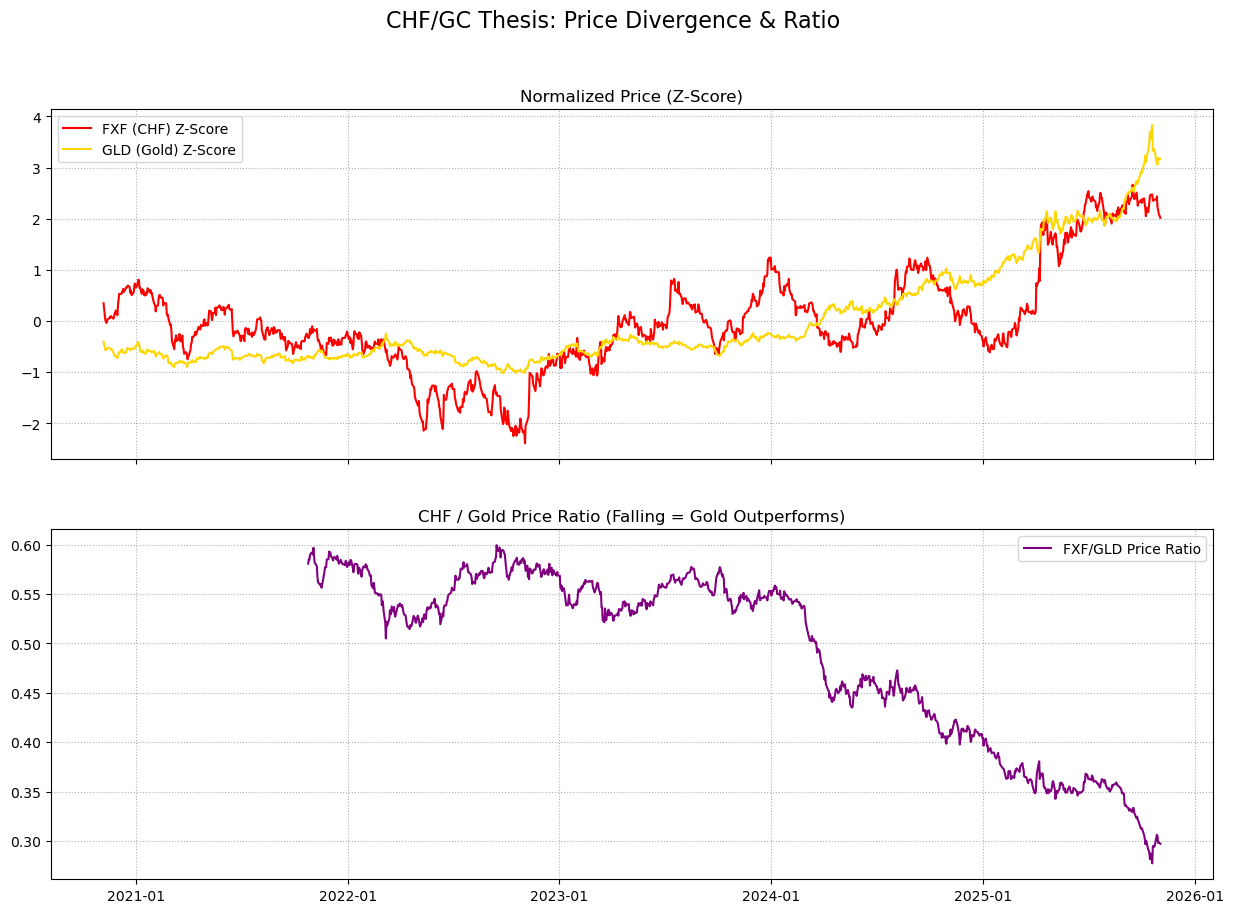

In [13]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of FXF vs. GLD.
# Plot 2: The FXF/GLD Ratio.
#
# This chart shows *what* is happening. When GLD outperforms FXF,
# the ratio in Plot 2 will fall.

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('CHF/GC Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['FXF'], label='FXF (CHF) Z-Score', color='red')
    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['CHF_GLD_Ratio'], label='FXF/GLD Price Ratio', color='purple')
    ax2.set_title('CHF / Gold Price Ratio (Falling = Gold Outperforms)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Driver (Intervention)...


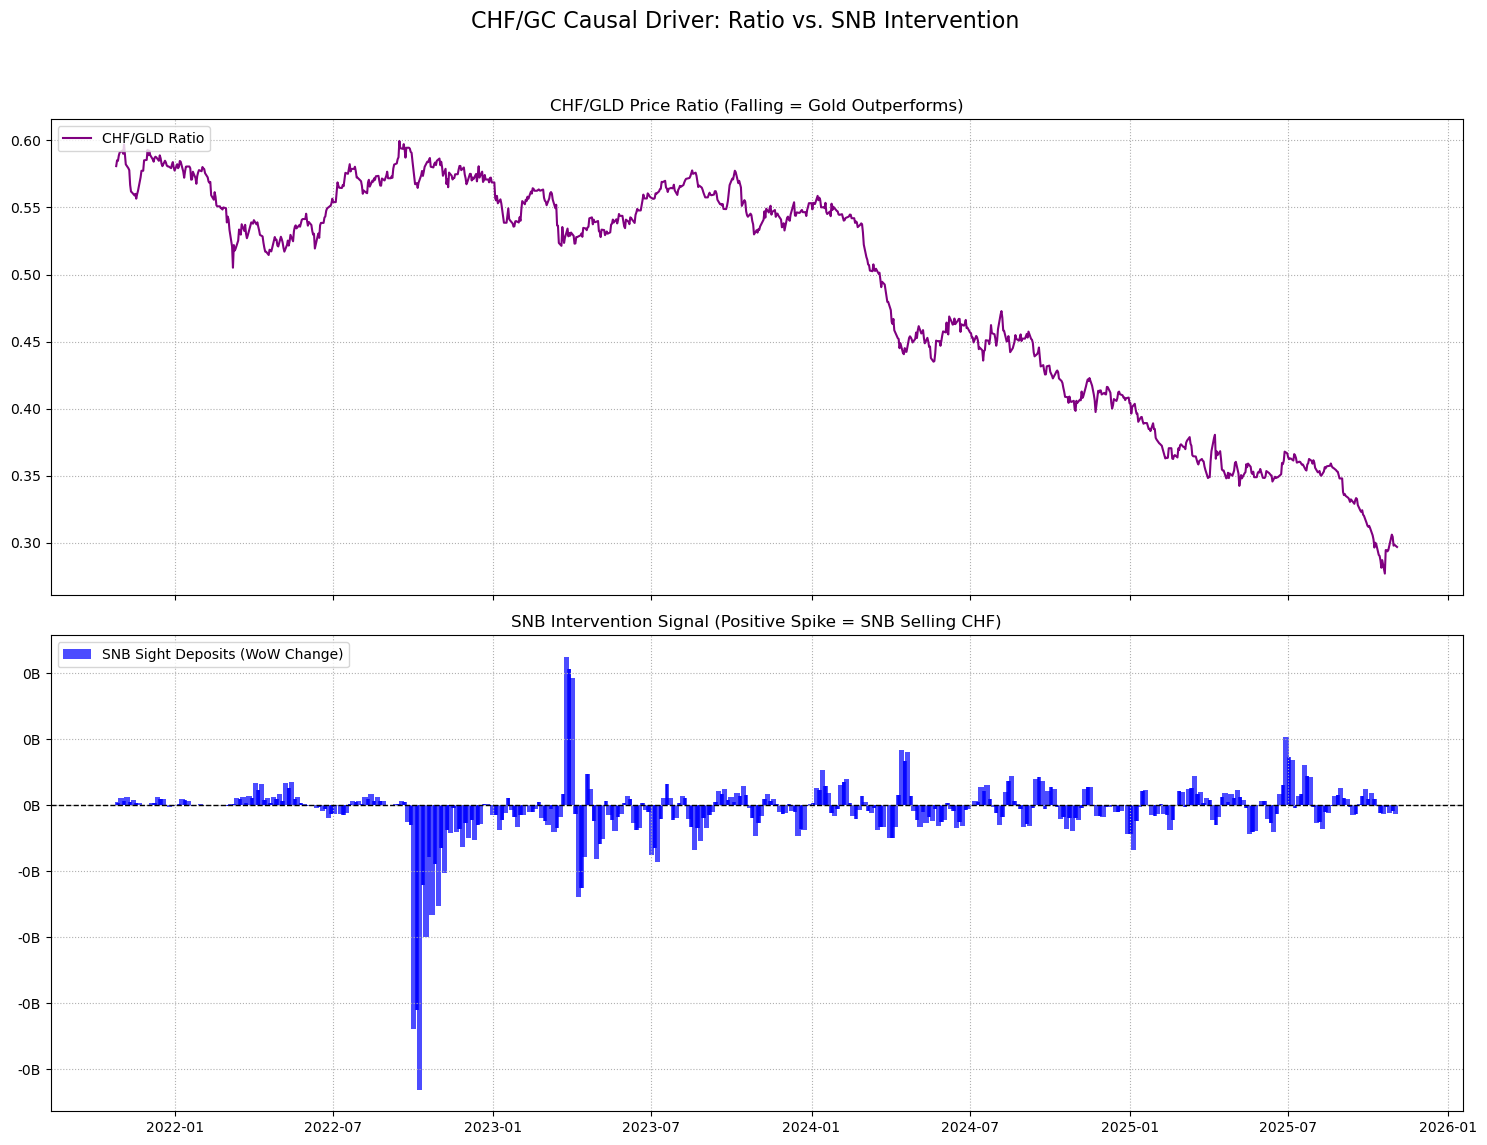

In [14]:
# Cell 10: Visualization - Causal Driver (SNB Intervention)
#
# Plot 1: The CHF/GLD Price Ratio.
# Plot 2: The SNB Intervention Signal (WoW change in Sight Deposits).
#
# This is the "arbitrage" chart.
# Thesis: A positive spike in Plot 2 (SNB selling CHF) should
# cause a *drop* in Plot 1 (CHF underperforms Gold).

try:
    print("Plotting Cell 10: Causal Driver (Intervention)...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('CHF/GC Causal Driver: Ratio vs. SNB Intervention', fontsize=16)

    # --- Plot 1: The Price Ratio ---
    ax1.plot(df.index, df['CHF_GLD_Ratio'], label='CHF/GLD Ratio', color='purple')
    ax1.set_title('CHF/GLD Price Ratio (Falling = Gold Outperforms)')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':')

    # --- Plot 2: The Intervention Signal ---
    # Use a bar chart to show the weekly *change*
    # --- Plot 2: The Intervention Signal ---
    ax2.bar(df.index, df['SNB_Intervention_WoW'],
            label='SNB Sight Deposits (WoW Change)',
            color='blue', alpha=0.7, width=3)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_title('SNB Intervention Signal (Positive Spike = SNB Selling CHF)')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle=':')
    
    # Format Y-axis to be readable (in Billions)
    from matplotlib.ticker import FuncFormatter
    def billions_formatter(x, pos):
        return f'{x / 1e9:.0f}B'
    ax2.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


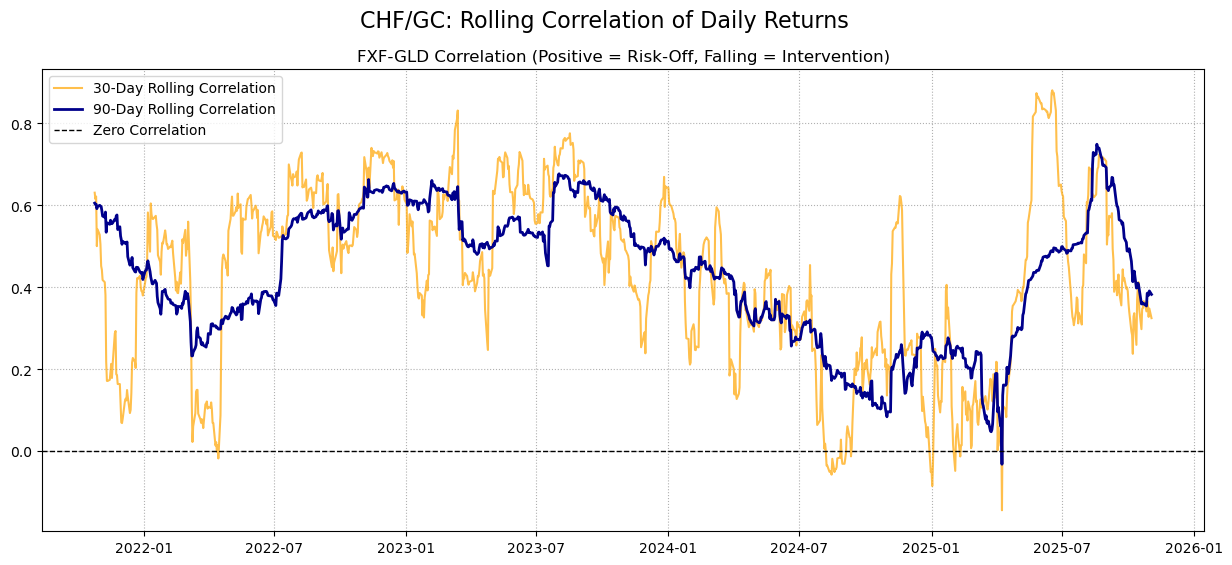

In [15]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the regime.
# * Positive = Classic "Global Risk-Off" (havens move together).
# * Falling/Negative = "SNB Intervention" (havens diverge).

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('CHF/GC: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Correlation')
    ax1.set_title('FXF-GLD Correlation (Positive = Risk-Off, Falling = Intervention)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

Plotting Cell 11a: Volatility Dashboard...


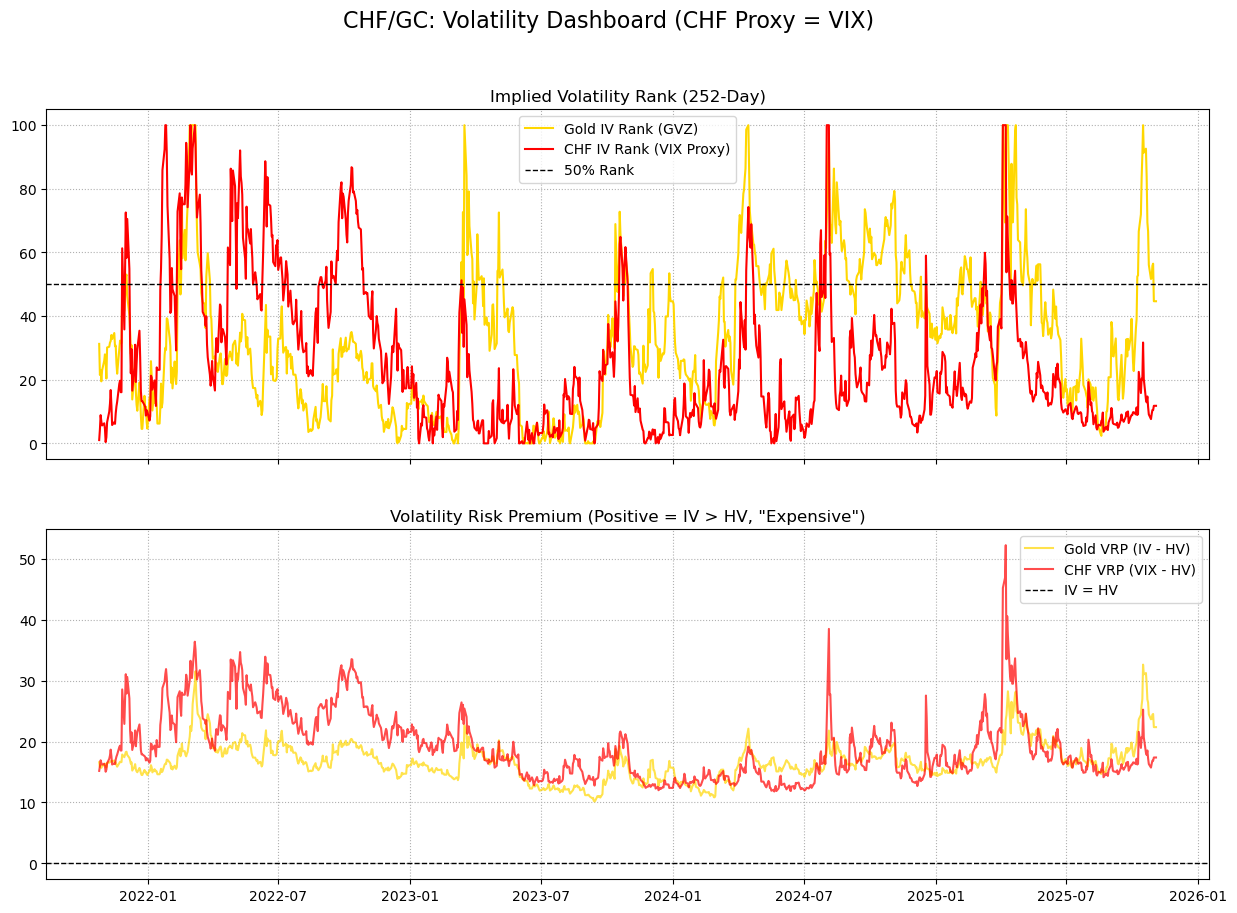

In [16]:
# Cell 11a: Visualization - Volatility Dashboard (Refactored)
#
# Plot the IV Rank and the Volatility Risk Premium (VRP) for both assets.
# Using VIX as the proxy for CHF vol.

try:
    print("Plotting Cell 11a: Volatility Dashboard...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('CHF/GC: Volatility Dashboard (CHF Proxy = VIX)', fontsize=16)

    # Plot 1: IV Rank (Tells you if vol is "high" or "low")
    ax1.plot(df.index, df['GVZ_IVR_252D'], label='Gold IV Rank (GVZ)', color='gold')
    ax1.plot(df.index, df['VIX_IVR_252D'], label='CHF IV Rank (VIX Proxy)', color='red')
    ax1.axhline(50, color='black', linestyle='--', linewidth=1, label='50% Rank')
    ax1.set_title('Implied Volatility Rank (252-Day)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Volatility Risk Premium (IV vs HV)
    ax2.plot(df.index, df['GLD_VRP'], label='Gold VRP (IV - HV)', color='gold', alpha=0.7)
    ax2.plot(df.index, df['FXF_VRP'], label='CHF VRP (VIX - HV)', color='red', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, label='IV = HV')
    ax2.set_title('Volatility Risk Premium (Positive = IV > HV, "Expensive")')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11a: Volatility plotting failed: {e}")

In [17]:
# Cell 12: LLM Analyst Synthesis (Refactored for Reasoning)
#
# This cell is for YOU. It runs the full qualitative analysis for
# the complex pairs trade.
# NEW: Re-added the "Explain your reasoning" commands from your
#      CHF/EUR notebook to get the full, verbose output.

try:
    print("Sending data to LLM for full analysis...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # Get the most recent intervention signal
    latest_intervention = df['SNB_Intervention_WoW'].dropna().iloc[-1]
    latest_intervention_date = df['SNB_Intervention_WoW'].dropna().index[-1].strftime('%Y-%m-%d')

    # --- Create Data Summary ---
    
    # 1. Macro Theme Summary
    macro_summary = f"""
--- MACRO THEME (Pair: CHF/GC) ---
- **Thematic Bias:** Managed vs. Unmanaged Haven
- **Signal Strength (Z-Score):** {latest_data['CHF_GLD_Spread_Norm']:.2f}
- **Signal Velocity (5D Change):** {latest_data['Signal_Velocity_5D']:.2f}
- **Regime Type (90D Corr):** {latest_data['Corr_90D']:.3f} (Positive = Correlated Haven, Low/Neg = Divergence)
- **SNB Intervention (WoW Change):** {latest_intervention / 1e9:.2f} Billion (as of {latest_intervention_date})
"""
    
    # 2. Volatility Dashboard Summary
    vol_summary = f"""
--- VOLATILITY DASHBOARD ---
- **Gold (GLD) IV Rank:** {latest_data['GVZ_IVR_252D']:.1f}%
- **Gold (GLD) VRP:** {latest_data['GLD_VRP']:.2f} (Positive = "Expensive")
- **CHF (FXF) IV Rank (VIX Proxy):** {latest_data['VIX_IVR_252D']:.1f}%
- **CHF (FXF) VRP:** {latest_data['FXF_VRP']:.2f} (Positive = "Expensive")
"""
    
    # 3. Determine Thematic Bias
    if latest_data['CHF_GLD_Spread_Norm'] < 0:
        directional_bias = "Long GLD / Short FXF"
    else:
        directional_bias = "Long FXF / Short GLD"

    # --- Create the LLM Prompt ---
    prompt = f"""
**Role:** You are an Independent Intelligence Desk Analyst, as per my thesis.

**Your Available Strategies:**
* Bull_Put_Spread, Bear_Call_Spread, Iron_Condor (Sell Premium)
* Calendar_Spread, Diagonal_Spread, Double_Diagonal_Spread (Buy Vega)
* No_Trade

**Latest OSINT Data:**
{macro_summary}
{vol_summary}

**Your Task (Provide a detailed 3-part recommendation):**
1.  **Macro Thesis Check:** What is the primary thematic driver?
    * Is the `SNB Intervention` signal active? Or is this a simple "Correlated Haven" trade?
    * The current thematic bias based on the Z-Score is **{directional_bias}**.
    * **Explain your reasoning in detail.**
2.  **Volatility Regimes:** Analyze the volatility for *both* legs of the trade.
    * **GLD:** IV Rank is {latest_data['GVZ_IVR_252D']:.1f}% ({"High/Expensive" if latest_data['GVZ_IVR_252D'] > 50 else "Low/Cheap"}).
    * **FXF (via VIX):** IV Rank is {latest_data['VIX_IVR_252D']:.1f}% ({"High/Expensive" if latest_data['VIX_IVR_252D'] > 50 else "Low/Cheap"}).
    * **Explain *why* this combination of volatility regimes is important for a pairs trade.**
3.  **Strategy Route (Pairs Trade):** Combine the thesis and the two vol regimes to build the optimal *pairs trade*.
    * **Explain your logic for each leg of the trade** and why it is the best fit from the strategy list.
    
    **Routing Logic:**
    * **Example 1 (SNB Intervention):** Thesis is `Long GLD / Short FXF`. GLD IVR is `Low` (cheap) and FXF IVR is `High` (expensive).
        * **Route:** "This is a perfect divergence. Buy a `Diagonal_Spread on GLD` (buy vega) and sell a `Bear_Call_Spread on FXF` (sell premium)."
    * **Example 2 (Correlated, Overpriced):** Thesis is "Range/Chop". Both IVRs are `High`.
        * **Route:** "This is a premium-selling opportunity. Sell an `Iron_Condor on GLD` and an `Iron_Condor on FXF`."
    * **Example 3 (Correlated, Cheap):** Thesis is "Breakout Coming". Both IVRs are `Low`.
        * **Route:** "This favors long vega. Buy a `Calendar_Spread on GLD` and a `Calendar_Spread on FXF`."

**CRITICAL:** Conclude your *entire* analysis with two, single, parsable lines:
ROUTED_STRATEGY_GLD: [strategy_name_for_GLD_leg]
ROUTED_STRATEGY_FXF: [strategy_name_for_FXF_leg]
(If a leg is not traded, use: No_Trade)
"""
    
    # Get LLM response
    llm_analyst_report = ask_llm(prompt) # This is the full, verbose report
    
    # --- Store data for subsequent cells ---
    latest_trade_data = latest_data.to_dict()
    latest_trade_data['Date'] = latest_data.name 
    latest_trade_rec = {"directional_bias": directional_bias} # Store bias
    
    print("\n--- 🤖 LLM ANALYST REPORT ---")
    print(llm_analyst_report)
    print("---------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Analyst synthesis failed: {e}")

Sending data to LLM for full analysis...



--- 🤖 LLM ANALYST REPORT ---
### 1. Macro Thesis Check

**Primary Thematic Driver:** The primary thematic driver here is the "Managed vs. Unmanaged Haven" theme, with a current Z-Score of -1.15 indicating a slight bias towards managed haven status for gold (GLD). However, the SNB Intervention signal is currently inactive (-0.00 Billion WoW change), suggesting that this trade is more about the correlation between the Swiss Franc (CHF) and gold rather than active central bank intervention.

**Reasoning:**
- The Z-Score of -1.15 suggests a managed haven status, implying that investors are seeking protection in gold during times of uncertainty.
- The Regime Type of 0.383 indicates a positive correlation between the CHF and gold, meaning they tend to move together. This supports the idea of a pairs trade where both assets are expected to behave similarly.

### 2. Volatility Regimes

**GLD IV Rank:** 44.7% (Low/Cheap)
- The low IV Rank suggests that GLD is currently undervalued in terms of 

In [18]:
# Cell 13: Signal Extraction (Corrected)
#
# This cell is for the MACHINE. It *parses* the report from Cell 12
# to find the two strategy recommendations.
# FIX: Added .strip(" *") to remove markdown formatting before parsing.

try:
    print("Parsing analyst report for clean signals...")
    
    strategy_gld = "No_Trade"
    strategy_fxf = "No_Trade"
    
    # Simple string parsing
    for line in llm_analyst_report.split('\n'):
        # --- THIS IS THE FIX ---
        # Strip leading/trailing spaces AND asterisks from the line
        clean_line = line.strip(" *") 
        
        if clean_line.startswith("ROUTED_STRATEGY_GLD:"):
            # Split and strip any remaining/internal asterisks
            strategy_gld = clean_line.split(":", 1)[1].strip().strip("*")
        
        if clean_line.startswith("ROUTED_STRATEGY_FXF:"):
            # Split and strip any remaining/internal asterisks
            strategy_fxf = clean_line.split(":", 1)[1].strip().strip("*")
            
    # --- Store for Cells 14 and 15 ---
    latest_trade_rec['strategy_gld'] = strategy_gld
    latest_trade_rec['strategy_fxf'] = strategy_fxf
    
    print(f"✅ Cell 13: Parsed Strategy (GLD): {strategy_gld}")
    print(f"✅ Cell 13: Parsed Strategy (FXF): {strategy_fxf}")

except Exception as e:
    print(f"❌ Cell 13: String parser failed: {e}")
    if 'latest_trade_rec' not in locals():
        latest_trade_rec = {}
    latest_trade_rec['strategy_gld'] = "No_Trade"
    latest_trade_rec['strategy_fxf'] = "No_Trade"

Parsing analyst report for clean signals...
✅ Cell 13: Parsed Strategy (GLD): Calendar_Spread
✅ Cell 13: Parsed Strategy (FXF): Calendar_Spread


In [19]:
# Cell 14: Position Sizing (NEW)
#
# Apply Step 3 of your thesis ("Trade & risk discipline").
# This cell sizes *both legs* of the pairs trade, splitting the
# total risk allocation (e.g., 50bps total -> 25bps per leg).

import math

# --- Define Your Risk Parameters ---
ACCOUNT_VALUE = 100000.00  # Your total trading capital
RISK_BPS_PER_TRADE = 50  # 50 bps = 0.50% risk for the *entire idea*
RISK_BPS_PER_LEG = RISK_BPS_PER_TRADE / 2 # 25 bps per leg

# --- Define Approx. Risk-Per-Contract (Based on your Specs) ---
RISK_PER_CONTRACT = {
    "Bull_Put_Spread": 350,
    "Bear_Call_Spread": 350,
    "Iron_Condor": 300,
    "Calendar_Spread": 150,
    "Diagonal_Spread": 200,
    "Double_Diagonal_Spread": 100,
    "No_Trade": 0
}

def get_leg_size(strategy_name, risk_bps):
    """Calculates contract size for a single trade leg."""
    if strategy_name == "No_Trade" or strategy_name not in RISK_PER_CONTRACT:
        return 0, 0.0
        
    risk_per_trade_usd = ACCOUNT_VALUE * (risk_bps / 10000.0)
    risk_per_unit = RISK_PER_CONTRACT.get(strategy_name, risk_per_trade_usd)
    
    if risk_per_unit <= 0:
         contracts = 0
    else:
        contracts = math.floor(risk_per_trade_usd / risk_per_unit)
        contracts = max(1, contracts) # Ensure at least 1 contract
        
    return contracts, risk_per_trade_usd

try:
    # --- Get Data from Cell 13 ---
    strategy_gld = latest_trade_rec['strategy_gld']
    strategy_fxf = latest_trade_rec['strategy_fxf']
    
    # --- Size Each Leg ---
    contracts_gld, risk_gld = get_leg_size(strategy_gld, RISK_BPS_PER_LEG)
    contracts_fxf, risk_fxf = get_leg_size(strategy_fxf, RISK_BPS_PER_LEG)
    
    # --- Store for Cell 15 ---
    latest_trade_rec['contracts_gld'] = contracts_gld
    latest_trade_rec['contracts_fxf'] = contracts_fxf
    
    # --- Print Final Trade Ticket ---
    print("--- ✅ FINAL PAIRS TRADE TICKET ---")
    print(f"Date:       {latest_trade_data['Date'].strftime('%Y-%m-%d')}")
    print(f"Theme:      Managed vs. Unmanaged Haven (CHF/GC)")
    print(f"Bias:       {latest_trade_rec['directional_bias']}")
    print(f"Total Risk: {RISK_BPS_PER_TRADE} bps on ${ACCOUNT_VALUE:,.2f} = ${risk_gld + risk_fxf:,.2f} max risk")
    print("---")
    print(f"LEG 1 (Gold):")
    print(f"  Strategy:   {strategy_gld}")
    print(f"  Size:       {contracts_gld} contracts")
    print(f"  Risk:       {RISK_BPS_PER_LEG} bps (${risk_gld:,.2f})")
    print("---")
    print(f"LEG 2 (CHF):")
    print(f"  Strategy:   {strategy_fxf}")
    print(f"  Size:       {contracts_fxf} contracts")
    print(f"  Risk:       {RISK_BPS_PER_LEG} bps (${risk_fxf:,.2f})")
    print("---------------------------------")

except Exception as e:
    if 'latest_trade_rec' not in locals():
        latest_trade_rec = {}
    latest_trade_rec['contracts_gld'] = 0
    latest_trade_rec['contracts_fxf'] = 0
    print(f"❌ Cell 14: Position Sizing failed: {e}")

--- ✅ FINAL PAIRS TRADE TICKET ---
Date:       2025-11-03
Theme:      Managed vs. Unmanaged Haven (CHF/GC)
Bias:       Long GLD / Short FXF
Total Risk: 50 bps on $100,000.00 = $500.00 max risk
---
LEG 1 (Gold):
  Strategy:   Calendar_Spread
  Size:       1 contracts
  Risk:       25.0 bps ($250.00)
---
LEG 2 (CHF):
  Strategy:   Calendar_Spread
  Size:       1 contracts
  Risk:       25.0 bps ($250.00)
---------------------------------


In [20]:
# Cell 15: Log to Trade Journal (Corrected)
import csv
import os.path

# --- NEW: Specific log file for this pair ---
LOG_FILE = 'quant/journal_chf_gc.csv'

try:
    data = latest_trade_data
    rec = latest_trade_rec

    fieldnames = [
        'Date', 'Pair', 'Theme', 'Directional_Bias',
        'Strategy_GLD', 'Contracts_GLD',
        'Strategy_FXF', 'Contracts_FXF',
        'Signal_ZScore', 'Signal_Velocity_5D', 'Corr_90D',
        'GLD_IVR', 'CHF_VIX_IVR', 'GLD_VRP', 'FXF_VRP', 
        'DFII10', 'SNB_Intervention_WoW', 'Analyst_Reasoning'
    ]
    
    log_data = {
        'Date': data['Date'].strftime('%Y-%m-%d'),
        'Pair': 'CHF_GC',
        'Theme': 'Managed_vs_Unmanaged_Haven',
        'Directional_Bias': rec.get('directional_bias'),
        'Strategy_GLD': rec.get('strategy_gld'),
        'Contracts_GLD': rec.get('contracts_gld'),
        'Strategy_FXF': rec.get('strategy_fxf'),
        'Contracts_FXF': rec.get('contracts_fxf'),
        'Signal_ZScore': data.get('CHF_GLD_Spread_Norm'),
        'Signal_Velocity_5D': data.get('Signal_Velocity_5D'),
        'Corr_90D': data.get('Corr_90D'),
        'GLD_IVR': data.get('GVZ_IVR_252D'),
        'CHF_VIX_IVR': data.get('VIX_IVR_252D'),
        'GLD_VRP': data.get('GLD_VRP'),
        'FXF_VRP': data.get('FXF_VRP'),
        'DFII10': data.get('DFII10'),
        'SNB_Intervention_WoW': data.get('SNB_Intervention_WoW'),
        'Analyst_Reasoning': llm_analyst_report
    }

    # --- NEW: Check if file is empty to write header ---
    file_exists = os.path.isfile(LOG_FILE)
    is_empty = os.path.getsize(LOG_FILE) == 0 if file_exists else True

    with open(LOG_FILE, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if is_empty:
            writer.writeheader()
        writer.writerow(log_data)
        
    print(f"\n--- ✅ Trade Logged ---")
    print(f"Successfully appended trade signal to {LOG_FILE}")
    
except Exception as e:
    print(f"❌ Cell 15: Logging to CSV failed: {e}")


--- ✅ Trade Logged ---
Successfully appended trade signal to quant/journal_chf_gc.csv
